In [1]:
import torch
import torch.nn.functional as F
from util.utils import generate_boxes
from models.cub_scale_model import Net
from util.data_aug import *
from util.bbox_util import *
import torchvision
from matplotlib.patches import Rectangle
from util import joint_transforms as t
from util.utils import convert_image_np, box_iou
from constants import IMAGENET_MEAN, IMAGENET_STD
from datasets.cub_fewshot import CUB_fewshot
import xml.etree.ElementTree as ET

os.environ['CUDA_VISIBLE_DEVICES']='3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = t.Compose([
                              t.ConvertFromPIL(),
                              t.ToPercentCoords(),
                              t.Resize(224),
                              t.Normalize(IMAGENET_MEAN, IMAGENET_STD),
                              t.ToTensor()  # no change to (0, 1)
                          ])

In [2]:
def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text)
        xmin = int(boxes.find("bndbox/xmin").text)
        ymax = int(boxes.find("bndbox/ymax").text)
        xmax = int(boxes.find("bndbox/xmax").text)

        list_with_single_boxes = [xmin, ymin, xmax, ymax]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes

In [3]:
anchors = generate_boxes(base_size=16, feat_height=14, feat_width=14,
                             min_box_side=25, img_size=224,
                             feat_stride=16, ratios=np.linspace(0.3, 3.5, num=15),
                             scales=np.array(range(2, 13)))
trainset = CUB_fewshot('/research/cbim/vast/tl601/Dataset/CUB_200_2011',
                          anchors=anchors, mode='base', img_size=224,
                          transform=transform)
testset = CUB_fewshot('/research/cbim/vast/tl601/Dataset/CUB_200_2011',
                          anchors=anchors, mode='val',img_size=224,
                          transform=transform)

base images 568 labels 10
val images 2950 labels 50


In [4]:
filename = 'Laysan_Albatross_0017_614'
index = [idx for idx, s in enumerate(testset.meta['image_names']) if filename in s][0]

# load head box
anchors_head = generate_boxes(base_size=16, feat_height=14, feat_width=14,
                             min_box_side=25, img_size=224,
                             feat_stride=16, ratios=np.linspace(0.3, 3.5, num=15),
                             scales=np.array(range(2, 13)))
head_filepath = os.path.join('/research/cbim/vast/tl601/Dataset/CUB_200_2011', 'head/002.Laysan_Albatross', filename+'.xml')
name, head_boxes = read_content(head_filepath)
head_boxes = torch.from_numpy(np.stack(head_boxes))
print(name, ' ', head_boxes)
head_boxes_ = head_boxes.clone().float()
# convert target to 224 images,
img = testset.data[index]
width, height = img.size
head_boxes_[0, 0] /= width
head_boxes_[0, 2] /= width
head_boxes_[0, 1] /= height
head_boxes_[0, 3] /= height
head_boxes_ = head_boxes_ * 224
ious_head = box_iou(head_boxes_, anchors_head)

iou_map_head = {i: None for i in range(10)}
for j in range(10):
    inds = torch.where((ious_head[0] >= j * 0.1) & (ious_head[0] < (j + 1) * 0.1))[0]
    if len(inds) != 0:
        iou_map_head[j] = inds
    else:
        del iou_map_head[j]
print('iou_map_head[3] ', iou_map_head.keys())
print(ious_head[0, iou_map_head[3]])
for j in range(10):
    if j in iou_map_head.keys():
        print(len(iou_map_head[j]))
    else:
        print(j)

Laysan_Albatross_0017_614.jpg   tensor([[139,  74, 296, 366]])
iou_map_head[3]  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
tensor([0.3077, 0.3023, 0.3060,  ..., 0.3195, 0.3147, 0.3242])
13799
5682
4160
3053
1982
880
234
31
3
9


In [5]:
img, target, label = testset.data[index], testset.target[index].copy(), \
                             testset.meta['image_labels'][index]
iou_map, ious = testset.iou_map[index], testset.ious[index]

target = np.stack((target, head_boxes[0]))
img, target, _ = testset.transform(img, target)
print('target ', target)

target  tensor([[0.0213, 0.1500, 0.9520, 0.9960],
        [0.3707, 0.1480, 0.7893, 0.7320]])


box new  tensor([[  4.7787,  33.6000, 213.2480, 223.1040],
        [ 83.0293,  33.1520, 176.8107, 163.9680]])


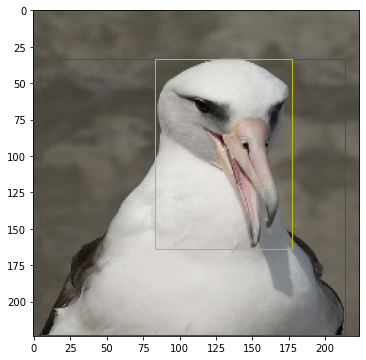

In [6]:
img_ = convert_image_np(torchvision.utils.make_grid(img.unsqueeze(0)),
                                    norm=True)
# draw = ImageDraw.Draw(img)
box = target * testset.img_size
print('box new ', box)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(img_)
x1, y1, x2, y2 = box[0]
patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1,
                  edgecolor='r', facecolor='none', fill=False)
ax.add_patch(patch)
x1, y1, x2, y2 = box[1]
patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1,
                  edgecolor='y', facecolor='none', fill=False)
ax.add_patch(patch)
plt.show()

In [7]:
# load model
saveroot = 'pretrain_ae_ord_cub_fewshot_lr1e03_spc5_cps5_iter50_img224_onlyord'
model = Net(pooling_size=7, pretrained=True, pooling_mode='align').to(device)
model_path = os.path.join('/research/cbim/vast/tl601/results/mnist/', saveroot, 'last.pth.tar')

print('loading net ckpt from ', model_path)
ckpt = torch.load(model_path)
epoch = ckpt['epoch']
filtered_dict = {}
model_dict = model.state_dict()
for k, v in ckpt['state_dict'].items():
    if k in model_dict:
        print('load ', k)
        filtered_dict[k] = v
model_dict.update(filtered_dict)
model.load_state_dict(model_dict)
acc_inst, acc_proto, acc_inst_other, \
acc_proto_other = ckpt['acc_inst'], ckpt['acc_proto'],\
                  ckpt['acc_inst_other'], ckpt['acc_proto_other']
print(("=> loaded model checkpoint epoch {} {}\n\tacc_inst {:.2f}"
       "\tacc_proto {:.2f}\tacc_inst_other {:.2f}"
       "\tacc_proto_other {:.2f}".format(epoch, name, acc_inst, acc_proto,
                                        acc_inst_other, acc_proto_other)))



Loading pretrained weights from /research/cbim/vast/tl601/projects/selfpaced/vgg16_caffe.pth
loading net ckpt from  /research/cbim/vast/tl601/results/mnist/pretrain_ae_ord_cub_fewshot_lr1e03_spc5_cps5_iter50_img224_onlyord/last.pth.tar
load  RCNN_base.0.weight
load  RCNN_base.0.bias
load  RCNN_base.2.weight
load  RCNN_base.2.bias
load  RCNN_base.5.weight
load  RCNN_base.5.bias
load  RCNN_base.7.weight
load  RCNN_base.7.bias
load  RCNN_base.10.weight
load  RCNN_base.10.bias
load  RCNN_base.12.weight
load  RCNN_base.12.bias
load  RCNN_base.14.weight
load  RCNN_base.14.bias
load  RCNN_base.17.weight
load  RCNN_base.17.bias
load  RCNN_base.19.weight
load  RCNN_base.19.bias
load  RCNN_base.21.weight
load  RCNN_base.21.bias
load  RCNN_base.24.weight
load  RCNN_base.24.bias
load  RCNN_base.26.weight
load  RCNN_base.26.bias
load  RCNN_base.28.weight
load  RCNN_base.28.bias
load  RCNN_top.0.weight
load  RCNN_top.0.bias
load  RCNN_top.3.weight
load  RCNN_top.3.bias
=> loaded model checkpoint epo

In [63]:
def compute_distance(img, target, ti, tj, iou1, iou2):
    img, target, ti, tj, iou1, iou2 = img.unsqueeze(0).to(device), target.to(device).float()*224, \
                                               ti.to(device), tj.to(device), \
                                               iou1.to(device), iou2.to(device)
    #print('target ', target, '\nti ', ti, '\ntj ', tj)
    
    # rois
    rois_0 = torch.cat((torch.arange(0, 1).float().view(-1, 1).to(device),
                        target[1].unsqueeze(0)), dim=1)
    rois_i = torch.cat((torch.arange(0, 1).float().view(-1, 1).to(device),
                        ti.unsqueeze(0)), dim=1)
    rois_j = torch.cat((torch.arange(0, 1).float().view(-1, 1).to(device),
                        tj.unsqueeze(0)), dim=1)
    
    _, pooled_0, out0 = model(img, rois_0) # (bs, 1, 84, 84), (bs, 1600)
    _, pooled_i, _ = model(img, rois_i)
    _, pooled_j, _ = model(img, rois_j)
    
    # compute accuracy self
    d_a0a1 = F.pairwise_distance(pooled_0, pooled_i)
    d_a0a2 = F.pairwise_distance(pooled_0, pooled_j)
    sub_pix = iou2 - iou1
    sub_d = d_a0a1 - d_a0a2
#     print('ioui ', iou1.item(), ' iouj ', iou2.item())
#     print('d_a0a1 ', d_a0a1.item(), ' d_a0a2 ', d_a0a2.item())
#     print('Ord ', (torch.sign(sub_d) == torch.sign(sub_pix)))
    return (torch.sign(sub_d) == torch.sign(sub_pix))

In [64]:
# AROUND HEAD random sample two ious and two box with these ious
def sample_boxes(iou_map_head, anchors_head, ious_head):
    keys = list(iou_map_head.keys())
    smp_iou = np.random.choice(keys, size=2)
    # print('smp iou ', smp_iou)
    ind1, ind2 = np.random.choice(iou_map_head[smp_iou[0]]), \
                 np.random.choice(iou_map_head[smp_iou[1]])
    # print('inds12 ', ind1, ind2)
    ti, tj, iou1, iou2 = anchors_head[ind1], anchors_head[ind2], \
                         ious_head[0][ind1], ious_head[0][ind2]
    #print('ti ', tj, ' iou1 ', iou1, ' iou2 ', iou2)
    return ti, tj, iou1, iou2

In [65]:
if False:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img_)
    x1, y1, x2, y2 = box[0]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1,
                      edgecolor='r', facecolor='none', fill=False)
    ax.add_patch(patch)
    x1, y1, x2, y2 = box[1]
    patch = Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1,
                      edgecolor='y', facecolor='none', fill=False)
    ax.add_patch(patch)
    patch = Rectangle((ti[0], ti[1]), ti[2]-ti[0], ti[3]-ti[1], linewidth=1,
                                  edgecolor='g', facecolor='none', fill=False)
    ax.add_patch(patch)
    patch = Rectangle((tj[0], tj[1]), tj[2] - tj[0], tj[3] - tj[1], linewidth=1,
                      edgecolor='b', facecolor='none', fill=False)
    ax.add_patch(patch)
    plt.show()

In [68]:
correct = 0 
for i in range(100):
    ti, tj, iou1, iou2=sample_boxes(iou_map_head, anchors_head, ious_head)
    pred = compute_distance(img, target, ti, tj, iou1, iou2)
    correct += (pred == True).sum().item()
print('correct ', correct)

correct  90
